In this file we train a XGboost model on our data on the BPI_Challenge_2012 dataset

### Importing the libraries

In [2]:
import xgboost as xgb
import pandas as pd
from aux_functions import split_data
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

### Loading the data

In [3]:
df = pd.read_csv('data/preprocessed/BPI_Challenge_2012.csv')
df.head()

,org:resource,lifecycle:transition,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ,position,next_concept:name,next_timestamp
0,112.0,COMPLETE,A_SUBMITTED,2011-10-01 00:38:44.546000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000,1,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880000+00:00
1,112.0,COMPLETE,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000,2,A_PREACCEPTED,2011-10-01 00:39:37.906000+00:00
2,112.0,COMPLETE,A_PREACCEPTED,2011-10-01 00:39:37.906000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000,3,W_Completeren aanvraag,2011-10-01 00:39:38.875000+00:00
3,112.0,SCHEDULE,W_Completeren aanvraag,2011-10-01 00:39:38.875000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000,4,W_Completeren aanvraag,2011-10-01 11:36:46.437000+00:00
4,112.0,COMPLETE,A_SUBMITTED,2011-10-01 08:08:58.256000+00:00,2011-10-01 08:08:58.256000+00:00,173691,5000,1,A_PARTLYSUBMITTED,2011-10-01 08:09:02.195000+00:00


### Specifying the columns

In [4]:
# Defining what category each column fall into
dropping_columns = ['time:timestamp', 'case:REG_DATE', 'case:concept:name', 'next_timestamp']
numerical_columns = ['org:resource', 'case:AMOUNT_REQ', 'position']
categorical_columns = ['lifecycle:transition', 'concept:name']
target_column = 'next_concept:name'

### Feature engineering

In [5]:
# Convert the target column to category
original_target = df[target_column].copy()
df[target_column] = df[target_column].astype('category')
df[target_column] = df[target_column].cat.codes

# One-hot encoding of the categorical columns 
df = pd.get_dummies(df, columns=categorical_columns)

# Columns that were one_hot_encoded
one_hot_encoded_columns = [col for col in df.columns if (col not in numerical_columns) and (col != target_column) and (col not in dropping_columns)]
one_hot_encoded_columns

['lifecycle:transition_COMPLETE',
 'lifecycle:transition_SCHEDULE',
 'lifecycle:transition_START',
 'concept:name_A_ACCEPTED',
 'concept:name_A_ACTIVATED',
 'concept:name_A_APPROVED',
 'concept:name_A_CANCELLED',
 'concept:name_A_DECLINED',
 'concept:name_A_FINALIZED',
 'concept:name_A_PARTLYSUBMITTED',
 'concept:name_A_PREACCEPTED',
 'concept:name_A_REGISTERED',
 'concept:name_A_SUBMITTED',
 'concept:name_O_ACCEPTED',
 'concept:name_O_CANCELLED',
 'concept:name_O_CREATED',
 'concept:name_O_DECLINED',
 'concept:name_O_SELECTED',
 'concept:name_O_SENT',
 'concept:name_O_SENT_BACK',
 'concept:name_W_Afhandelen leads',
 'concept:name_W_Beoordelen fraude',
 'concept:name_W_Completeren aanvraag',
 'concept:name_W_Nabellen incomplete dossiers',
 'concept:name_W_Nabellen offertes',
 'concept:name_W_Valideren aanvraag',
 'concept:name_W_Wijzigen contractgegevens']

### Splitting the dataset into train and test dataframes

In [6]:
# Splitting the data
train_df, test_df = split_data(df, ratio=0.8, report=True)
X_train = train_df[numerical_columns + one_hot_encoded_columns]
y_train = train_df[target_column]
X_test = test_df[numerical_columns + one_hot_encoded_columns]
y_test = test_df[target_column]

# Getting the feature types for xgboost
ft = ['q' if feature in numerical_columns else 'c' for feature in X_train.columns]

Original size: 262200
Train size: 186785
Test size: 37781
Ratio: 0.8317599280389729
Dropped cases in both sets: 888
Dropped rows from dataset: 37634


### Training the model

In [7]:
# Create DMatrix for training and testing
train_dmatrix = xgb.DMatrix(X_train, y_train, feature_types=ft, enable_categorical=True)
test_dmatrix = xgb.DMatrix(data=X_test, label=y_test, feature_types=ft, enable_categorical=True)

In [8]:
# Create XGBoost parameters
params = {
    'eta': 0.3,  # the training step for each iteration
    'objective': 'multi:softmax',  # for multi-class classification
    'num_class': len(df[target_column].unique()),  # number of classes
    'eval_metric': 'merror' # evaluation metric
}

In [9]:
# Train the XGBoost model
xgb_model = xgb.train(params, train_dmatrix, num_boost_round=10)

### Predicting the result and Evaluation

In [10]:
# Evaluate the model
predictions = xgb_model.predict(test_dmatrix)

In [11]:
# Calculate the f1, precision, recall, and accuracy
f1 = f1_score(y_test, predictions, average='weighted')
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
accuracy = accuracy_score(y_test, predictions)

print(f'F1: {f1:.5f}, Precision: {precision:.5f}, Recall: {recall:.5f}, Accuracy: {accuracy:.5f}')

F1: 0.71521, Precision: 0.72765, Recall: 0.73468, Accuracy: 0.73468


In [12]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.70      0.01      0.02       810
           1       0.28      0.36      0.32       293
           2       0.38      0.20      0.26       293
           3       0.32      0.03      0.05       266
           4       0.49      0.34      0.40      1202
           5       0.74      0.49      0.59       793
           6       1.00      1.00      1.00      2123
           7       0.50      0.45      0.47      1194
           8       0.34      0.31      0.32       293
           9       0.71      0.56      0.63      2123
          10       0.44      0.03      0.05       293
          11       0.40      0.15      0.22       387
          12       0.66      0.83      0.74      1069
          13       0.47      0.44      0.46        99
          14       0.62      0.62      0.62      1069
          15       1.00      1.00      1.00      1069
          16       0.50      0.94      0.65       509
          17       0.69    

In [13]:
# We can see if the model is overfitting by comparing the training and testing error
train_predictions = xgb_model.predict(train_dmatrix)   
f1 = f1_score(y_train, train_predictions, average='weighted')
precision = precision_score(y_train, train_predictions, average='weighted')
recall = recall_score(y_train, train_predictions, average='weighted')
train_accuracy = accuracy_score(y_train, train_predictions)

print(f'Training F1: {f1:.5f}, Training Precision: {precision:.5f}, Training Recall: {recall:.5f}, Training Accuracy: {train_accuracy:.5f}')

Training F1: 0.74671, Training Precision: 0.75699, Training Recall: 0.76695, Training Accuracy: 0.76695


c:\Users\Gustas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
# find the mapping with the orginal_target and encoded one
mapping = dict(zip(df[target_column], original_target))

In [18]:
# predicting a single instance 
position = 45
single_instance = X_test.iloc[position].values.reshape(1, -1)
single_instance_dmatrix = xgb.DMatrix(data=single_instance, feature_names=list(X_test.columns), feature_types=ft, enable_categorical=True)
single_instance_prediction = xgb_model.predict(single_instance_dmatrix)

# Finding the mapping of the prediction to the actual value
print(f'Prediction: {mapping[single_instance_prediction[0]]},\nActual: {mapping[y_test.iloc[position]]}')

Prediction: W_Completeren aanvraag,
Actual: W_Completeren aanvraag


In [27]:
# predicting a single instance 
position = 100
single_instance = X_test.iloc[position].values.reshape(1, -1)
single_instance_dmatrix = xgb.DMatrix(data=single_instance, feature_names=list(X_test.columns), feature_types=ft, enable_categorical=True)
single_instance_prediction = xgb_model.predict(single_instance_dmatrix)

# Finding the mapping of the prediction to the actual value
print(f'Prediction: {mapping[single_instance_prediction[0]]},\nActual: {mapping[y_test.iloc[position]]}')

Prediction: O_SELECTED,
Actual: O_SELECTED


In [ ]:
# predicting suffix

FileNotFoundError: [Errno 2] No such file or directory: 'figs/feature_importance_XGboost_2012.png'

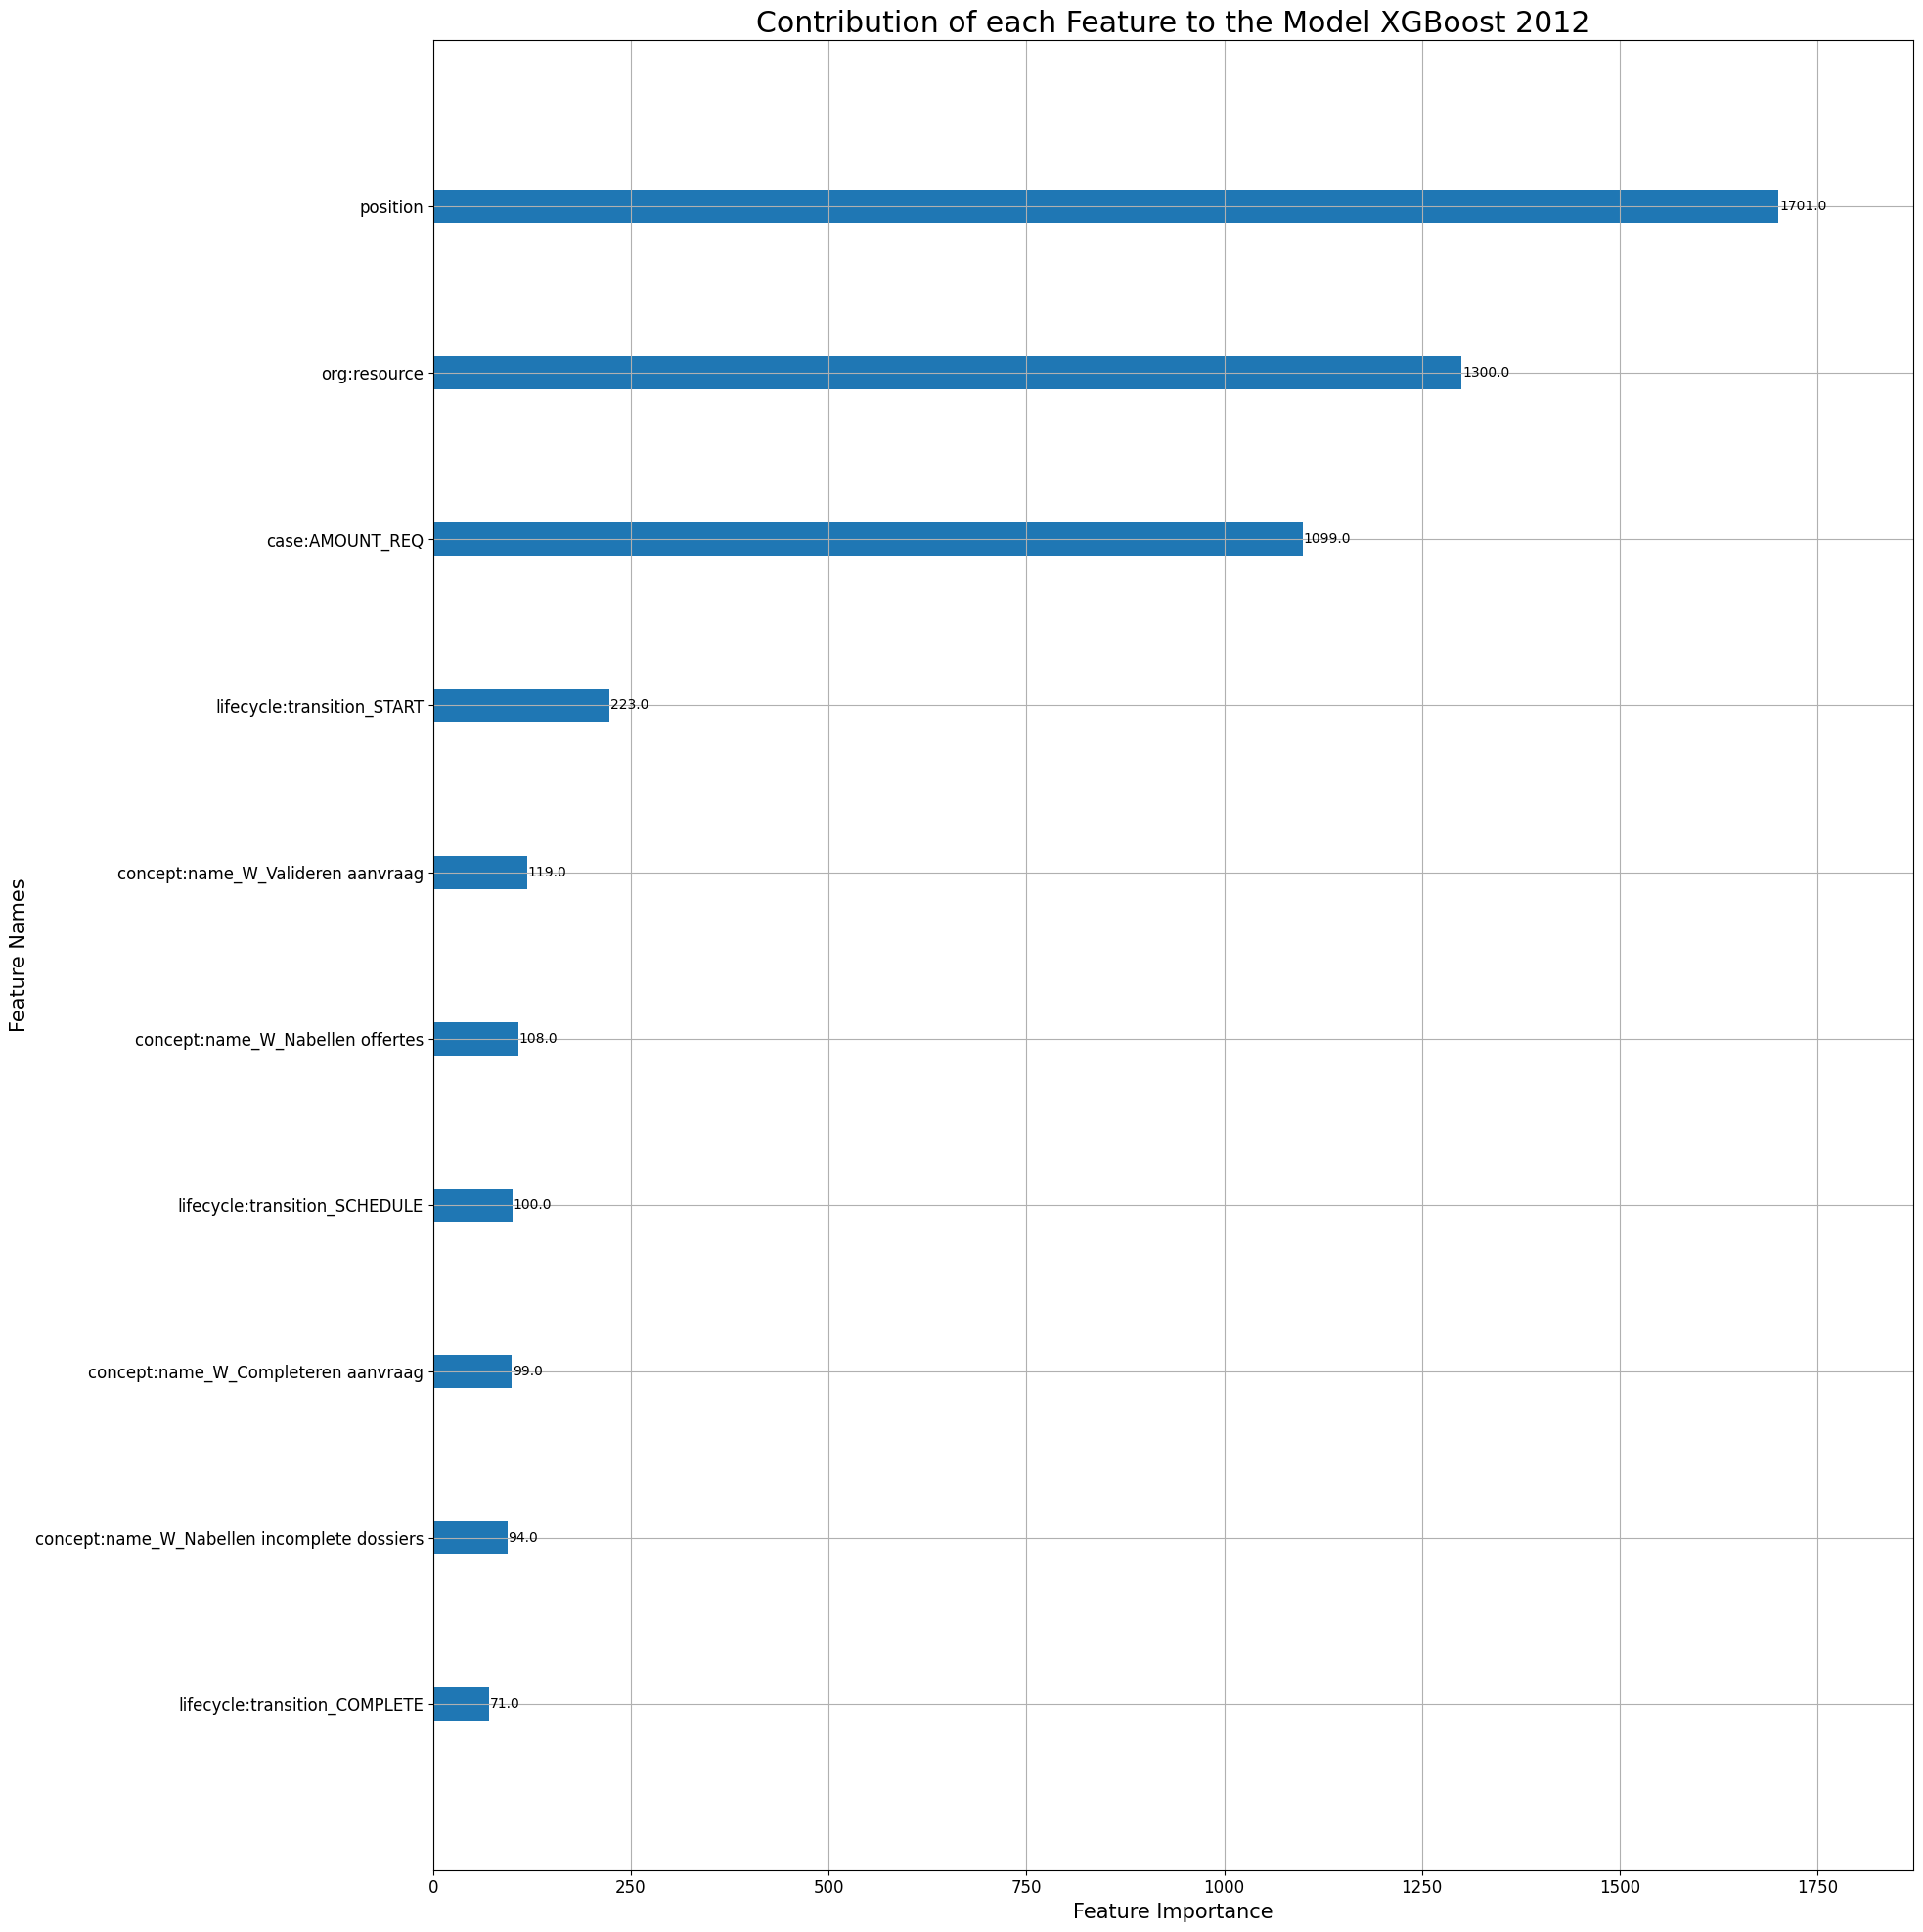

In [22]:
# Plotting the feature importance of the top 10 features

xgb.plot_importance(xgb_model, max_num_features=6, importance_type='weight')
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.rcParams.update({'font.size': 18})
plt.ylabel('Feature Names', fontsize=18)
plt.xlabel('Feature Importance', fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.tight_layout()
plt.title('Contribution of each Feature to the Model XGBoost 2012')
plt.savefig('figs/feature_importance_XGboost_2012.png')
plt.show()